# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [48]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


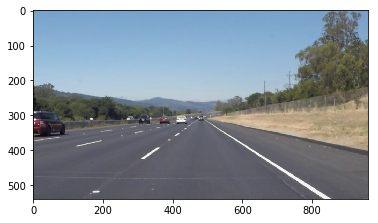

In [49]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [50]:
import cv2
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_line(img, line, color=[255, 0, 0], thickness=3):
    cv2.line(img, (int(line.p0_x), int(line.p0_y)), (int(line.p1_x), int(line.p1_y)), color, thickness)


def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    for line in lines:
        draw_line(img, line, color, thickness)


def draw_line_image(img, lines):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns hough lines found in image.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [51]:
# A convenient class for lines
class Line:
    def __init__(self, line):
        self.p0_x = line[0]
        self.p0_y = line[1]
        self.p1_x = line[2]
        self.p1_y = line[3]
        
    def to_list(self):
        return [self.p0_x, self.p0_y, self.p1_x, self.p1_y]

    def Value(self, x):
        return self.Slope() * x + self.Bias()

    def Slope(self):
        return (self.p1_y - self.p0_y) / (self.p1_x - self.p0_x)

    def Bias(self):
        return self.p0_y - self.Slope() * self.p0_x

    def __str__(self):
        return "[(%d,%d), (%d,%d), %.3f, %.3f]" % (self.p0_x, self.p0_y, self.p1_x, self.p1_y, self.Slope(), self.Bias())

    def __repr__(self):
        return self.__str__()

In [52]:
def detect_edges(image):
    # grayscale the image
    gray_img = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray_img = gaussian_blur(gray_img, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 175
    edge_img = canny(blur_gray_img, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    y_max = imshape[0]
    x_max = imshape[1]
    top = 0.6 * y_max
    vertices = np.array([[(120, y_max), (x_max / 2 - 40, top), (x_max / 2 + 40, top), (x_max - 10, y_max)]],
                        dtype=np.int32)
    masked_edge_img = region_of_interest(edge_img, vertices)
    return masked_edge_img


def detect_lines(image):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 3  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25  # minimum number of pixels making up a line
    max_line_gap = 100  # maximum gap in pixels between connectable line segments
    lines = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    return [Line(i.tolist()[0]) for i in lines]

# Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [53]:
import os
image_folder = "test_images/"
output_image_folder = "test_images_output/"

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

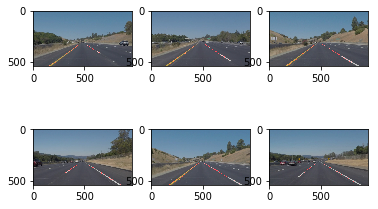

In [84]:
for file in os.listdir(image_folder):
    image = mpimg.imread(os.path.join(image_folder, file))
    
    # Detect edges and lines
    edge_img = detect_edges(image)
    lines = detect_lines(edge_img)
    
    #Create images
    lines_img = draw_line_image(edge_img, lines)
    weight_img = weighted_img(lines_img, image)
    
    mpimg.imsave(os.path.join(output_image_folder, file), weight_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [55]:
import itertools
import math
import statistics

class DBSCAN:
    def __init__(self, l, m_eps=0.1, b_eps=float('inf')):
        self.lines = l
        self.visited = set()
        self.cluster_groups = list()

        self.m_eps = m_eps
        self.b_eps = b_eps

    def is_neighbor(self, line, l):
        delta_m = math.fabs(line.Slope() - l.Slope()) < self.m_eps
        delta_b = math.fabs(line.Bias() - l.Bias()) < self.b_eps
        return delta_m and delta_b

    def scan_neighborhood(self, line):
        neigborhood = []
        for l in [x for x in self.lines if x is not line]:
            if self.is_neighbor(line, l):
                neigborhood.append(l)
        return set(neigborhood)

    def expand_cluster(self, cluster, neighbors):
        number_of_visited = 0

        while number_of_visited < len(self.visited):
            number_of_visited = len(self.visited)
            for n in neighbors.copy():
                if n not in self.visited:
                    self.visited.add(n)
                    sub_neighbors = self.scan_neighborhood(n)
                    # join neighbor groups
                    neighbors.update(sub_neighbors)
                    break

                not_in_any_cluster = any(n not in c for c in self.cluster_groups)
                if not_in_any_cluster:
                    cluster.add(n)

    def cluster_lines(self):
        unvisited_lines = (x for x in self.lines if x not in self.visited)
        for l in unvisited_lines:
            self.visited.add(l)
            neighbors = self.scan_neighborhood(l)

            # create new cluster
            self.cluster_groups.append(set([l]))
            self.expand_cluster(self.cluster_groups[-1], neighbors)
        return self.cluster_groups

def DvideIntoLeftRightClusters(line_cluster):
    left_clusters = []
    right_clusters = []
    for cluster in line_cluster:
        slopes = [x.Slope() for x in cluster]
        if statistics.mean(slopes) <= 0.0:
            left_clusters.append(cluster)
        else:
            right_clusters.append(cluster)

    # sort by decreasing number of elements in cluster
    left_clusters =  sorted(left_clusters, key=lambda x: len(x), reverse=True)
    right_clusters = sorted(right_clusters, key=lambda x: len(x), reverse=True)
    return {'left': left_clusters, 'right': right_clusters}

def linear_curve_fit(cluster):
    all_points = [c.to_list() for c in cluster]
    all_points = list(itertools.chain(*all_points))
    x_values = all_points[::2]
    y_values = all_points[1::2]
    dim = 1
    return np.poly1d(np.polyfit(x_values, y_values, dim))

def inverse_linear_curve(curve):
    m_ = 1 / curve.coeffs[0]
    b_ = -curve.coeffs[1] / curve.coeffs[0]
    return np.poly1d([m_, b_])


In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
def process_image(image):

    # Detect edges and lines
    edge_img = detect_edges(image)
    lines = detect_lines(edge_img)
    
    #Draw all detected lines on image
    lines_img = draw_line_image(edge_img, lines)
    
    # Cluster all detected lines by their slope using DBSCAN
    line_clusters = DBSCAN(lines).cluster_lines()
    
    # Split line clusters in two groups (left and right) depending on their slope sign (m≤0=left, m>0=right).
    # Each group is then sorted from large clusters to smaller clusters.
    splitted_clusters = DvideIntoLeftRightClusters(line_clusters)
    
    # Fit curves into the largest left and right line cluster
    lane_curves = []
    if splitted_clusters['left']:
        left_lane_curve = linear_curve_fit(splitted_clusters['left'][0])
        lane_curves.append(left_lane_curve)
    
    if splitted_clusters['right']:
        right_lane_curve = linear_curve_fit(splitted_clusters['right'][0])
        lane_curves.append(right_lane_curve)
        
    # Draw lane curves on the line image. The inverse function of the linear curves are used
    # so that the min/max y-values of the line can be specified easily
    for c in lane_curves:
        inverse = inverse_linear_curve(c)
        lane_line = Line([inverse(550), 550, inverse(330), 330])
        draw_line(lines_img, lane_line, color=[255, 255, 0], thickness=3)
    
    return weighted_img(lines_img, image)

Let's try the one with the solid white lane on the right first ...

In [58]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:11<00:00, 21.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.39 s, sys: 1.07 s, total: 5.46 s
Wall time: 12.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [60]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 72%|███████▏  | 493/682 [00:23<00:09, 20.44it/s]


100%|█████████▉| 681/682 [00:34<00:00, 19.70it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.6 s, sys: 3.04 s, total: 16.7 s
Wall time: 35.6 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [62]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 45%|████▌     | 114/251 [00:16<00:23,  5.91it/s]

OverflowError: signed integer is less than minimum

In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))